# Predicting Red Wine Quality with a Support Vector Machine

## Wine Data
Data from http://archive.ics.uci.edu/ml/datasets/Wine+Quality

### Citations
<pre>
Dua, D. and Karra Taniskidou, E. (2017). 
UCI Machine Learning Repository [http://archive.ics.uci.edu/ml/index.php]. 
Irvine, CA: University of California, School of Information and Computer Science.
</pre>

<pre>
P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. 
Modeling wine preferences by data mining from physicochemical properties.
In Decision Support Systems, Elsevier, 47(4):547-553. ISSN: 0167-9236.
</pre>

Available at:
- [@Elsevier](http://dx.doi.org/10.1016/j.dss.2009.05.016)
- [Pre-press (pdf)](http://www3.dsi.uminho.pt/pcortez/winequality09.pdf)
- [bib](http://www3.dsi.uminho.pt/pcortez/dss09.bib)

## Setup

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

red_wine = pd.read_csv('../../ch_09/data/winequality-red.csv')

## EDA

In [2]:
red_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [3]:
red_wine.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [4]:
red_wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


<AxesSubplot:title={'center':'Red Wine Quality Scores'}, xlabel='count of wines', ylabel='quality score'>

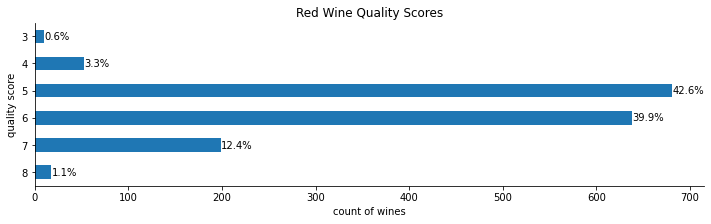

In [5]:
def plot_quality_scores(df, kind):
    ax = df.quality.value_counts().sort_index().plot.barh(
        title=f'{kind.title()} Wine Quality Scores', figsize=(12, 3)
    )
    ax.axes.invert_yaxis()
    for bar in ax.patches:
        ax.text(
            bar.get_width(), 
            bar.get_y() + bar.get_height()/2, 
            f'{bar.get_width()/df.shape[0]:.1%}',
            verticalalignment='center'
        )
    plt.xlabel('count of wines')
    plt.ylabel('quality score')

    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

    return ax

plot_quality_scores(red_wine, 'red')

## Making the `high_quality` column

In [6]:
red_wine['high_quality'] = pd.cut(red_wine.quality, bins=[0, 6, 10], labels=[0, 1])
red_wine.high_quality.value_counts(normalize=True)

0    0.86429
1    0.13571
Name: high_quality, dtype: float64

## Building your first Support Vector Machine

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

y = red_wine.pop('high_quality')
X = red_wine.drop(columns=['quality'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=0, stratify=y
)

pipeline = Pipeline([
    ('scale', StandardScaler()), 
    ('svm', SVC(C=5, random_state=0, probability=True))
]).fit(X_train, y_train)

### Evaluating the SVM
Get the predictions:

In [8]:
quality_preds = pipeline.predict(X_test)

Look at the classification report:

In [9]:
from sklearn.metrics import classification_report
print(classification_report(y_test, quality_preds))

              precision    recall  f1-score   support

           0       0.92      0.94      0.93       138
           1       0.56      0.45      0.50        22

    accuracy                           0.88       160
   macro avg       0.74      0.70      0.71       160
weighted avg       0.87      0.88      0.87       160



Review the confusion matrix:

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Actual', ylabel='Model Prediction'>

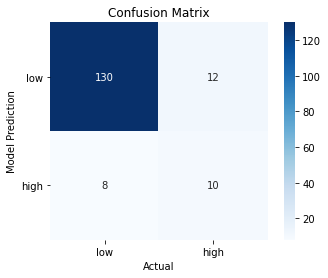

In [10]:
from ml_utils.classification import confusion_matrix_visual

confusion_matrix_visual(y_test, quality_preds, ['low', 'high'])

Examine the precision-recall curve:

<AxesSubplot:title={'center':'Precision-recall curve\n AP: 0.48 | AUC: 0.45'}, xlabel='Recall', ylabel='Precision'>

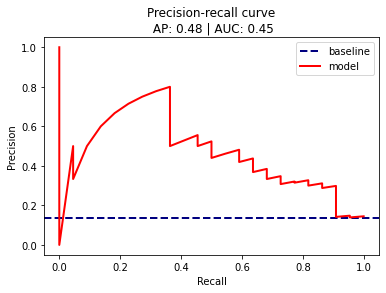

In [11]:
from ml_utils.classification import plot_pr_curve

plot_pr_curve(y_test, pipeline.predict_proba(X_test)[:,1])

<hr>
<div>
    <a href="./exercise_4.ipynb">
        <button>&#8592; Previous Solution</button>
    </a>
    <a href="../../ch_10/red_wine.ipynb">
        <button style="float: right;">Chapter 10 &#8594;</button>
    </a>
</div>
<hr>